# Design and operations of energy technologies for a household (PV, heat pump, battery)


In this case study we find the optimal sizes and operations of a heat pump, a set of solar panels and a battery to power the energy needs (heat and electricity) of a household over 1 year. The household, which has certain heat and electricity demand profiles, has an existing connection to the grid and an existing gas boiler. The emissions of CO2 are taxed.

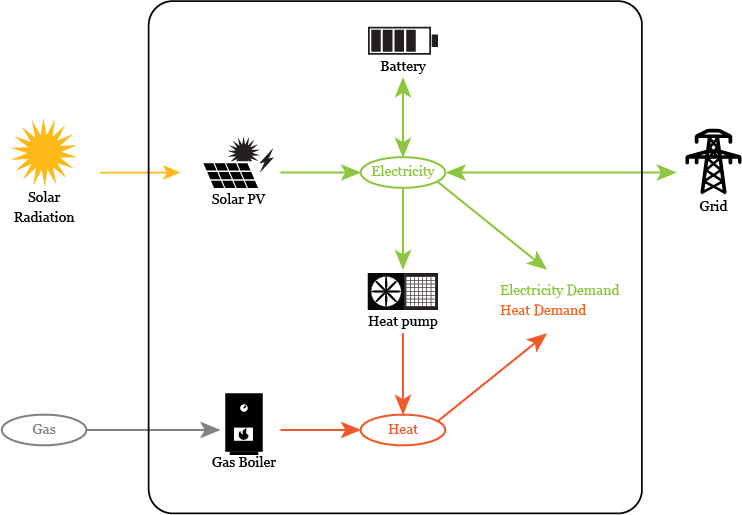

## Create templates
We set the input data path and in this directory we can add input data templates for the model configuration and the topology with the function create_optimization_templates.


In [1]:
import adopt_net0 as adopt
import json
import pandas as pd
from pathlib import Path
import numpy as np

input_data_path = Path("./caseStudies/household")
adopt.create_optimization_templates(input_data_path)

C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\genericTechnologies\conv1.py:13: SyntaxWarning: invalid escape sequence '\s'
  """
C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\genericTechnologies\conv2.py:16: SyntaxWarning: invalid escape sequence '\s'
  """
C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\genericTechnologies\conv3.py:17: SyntaxWarning: invalid escape sequence '\l'
  """
C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\genericTechnologies\stor.py:17: SyntaxWarning: invalid escape sequence '\l'
  """
C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\specificTechnologies\hydro_open.py:11: SyntaxWarning: invalid escape sequence '\l'
  """
C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\networks\network.py:21: SyntaxWarning: invalid escape sequence '\g'
  """


## Adapt Topology
We need to adapt the topology as well as the model configuration file to our case study. This can be done either in the file itself (Topology.json) or, as we do it here, via some lines of code.
For the topology, we need to change the following:
- Change nodes: household
- Change carriers: electricity, heat and gas
- Change investment periods: period1
- The options regarding the time frame we can leave at the default (one year with hourly operation)

In [2]:
# Load json template
with open(input_data_path / "Topology.json", "r") as json_file:
    topology = json.load(json_file)
# Nodes
topology["nodes"] = ["household"]
# Carriers:
topology["carriers"] = ["electricity", "heat", "gas"]
# Investment periods:
topology["investment_periods"] = ["period1"]
# Save json template
with open(input_data_path / "Topology.json", "w") as json_file:
    json.dump(topology, json_file, indent=4)


## Adapt Model Configurations
Now, we need to adapt the model configurations respectively. In this case, we don't use any particular algorithm (clustering, time staging etc), so here we only specify what we want to minimize - costs in this example - and set the gap for the MILP solver to a desired value. 


In [3]:
# Load json template
with open(input_data_path / "ConfigModel.json", "r") as json_file:
    configuration = json.load(json_file)
# Change objective
configuration["optimization"]["objective"]["value"] = "costs"
# Set MILP gap
configuration["solveroptions"]["mipgap"]["value"] = 0.02
# Save json template
with open(input_data_path / "ConfigModel.json", "w") as json_file:
    json.dump(configuration, json_file, indent=4)

## Define input data
We first create all required input data files based on the topology file and then add the existing technologies (gas boiler, 3kW capacity) and potential new technologies (heat pump, PV, battery). Since we have potentially a PV, we need to specify the location of the household.
Additionally, we copy over technology data to the input data folder


In [4]:
adopt.create_input_data_folder_template(input_data_path)

# Add heat pump, PV and battery as new technologies
with open(input_data_path / "period1" / "node_data" / "household" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["Photovoltaic","HeatPump_AirSourced","Storage_Battery"]
technologies["existing"] = {"Boiler_Small_NG": 0.003}

with open(input_data_path / "period1" / "node_data" / "household" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Copy over technology files
adopt.copy_technology_data(input_data_path)

# Specify location of the household
node_location = pd.read_csv(input_data_path / "NodeLocations.csv", sep=';', index_col=0, header=0)
node_lon = 4.9
node_lat = 52
node_alt = 10
node_name = 'household'
node_location.at['household', 'lon'] = node_lon
node_location.at['household', 'lat'] = node_lat
node_location.at['household', 'alt'] = node_alt
node_location = node_location.reset_index()
node_location.to_csv(input_data_path / "NodeLocations.csv", sep=';', index=False)


## Read demand data, import limits/price
In this case study we want to model an hourly heat and electricity demand of the household, with variable electricity prices. In addition, we set a fixed value for gas and electricity import limits and gas prices. As such we:
- Read day-ahead electricity prices (hourly for the Netherlands in 2023)
- Read hourly heat (total 7.3MWh) and electricity demand (total 4MWh)
- Limit import of gas (5kW) and electricity (8kW)
- Set an import price on gas of 120 EUR/MWh

Finally, we set a carbon tax to 100 EUR/t.

N.B all the data should be in MW, EUR/MWh, EUR/t, t/MWh

In [5]:
# Read hourly data from Excel
user_input_path = "./caseStudies/data/data_household.xlsx"
household_hourly_data = pd.read_excel(user_input_path, header=0, nrows=8760)

# Save the hourly data to the carrier's file in the case study folder
# electricity demand and price
el_price = household_hourly_data.iloc[:, 2]
el_demand = household_hourly_data.iloc[:, 1]
heat_demand = household_hourly_data.iloc[:, 0]
adopt.fill_carrier_data(input_data_path, value_or_data=el_price, columns=['Import price'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=el_price, columns=['Export price'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=el_demand, columns=['Demand'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=heat_demand, columns=['Demand'], carriers=['heat'], nodes=['household'])

# Set import limits/cost
adopt.fill_carrier_data(input_data_path, value_or_data=0.005, columns=['Import limit'], carriers=['gas'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=0.008, columns=['Import limit'], carriers=['electricity'], nodes=['household'])
adopt.fill_carrier_data(input_data_path, value_or_data=120, columns=['Import price'], carriers=['gas'], nodes=['household'])

# Set carbon emission price
carbon_price = np.ones(8760)*100
carbon_cost_path = "./caseStudies/household/period1/node_data/household/CarbonCost.csv"
carbon_cost_template = pd.read_csv(carbon_cost_path, sep=';', index_col=0, header=0)
carbon_cost_template['price'] = carbon_price
carbon_cost_template = carbon_cost_template.reset_index()
carbon_cost_template.to_csv(carbon_cost_path, sep=';', index=False)

## Run model
Now, we have defined all required data to run the model

In [6]:
m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Reading data from caseStudies\household
Topology read successfully
Model Configuration read successfully
Time series read successfully
Node Locations read successfully
Energy balance options read successfully
Deriving performance data for Heat Pump...


Complete:  96.0 %99999999999 %%

Technology data read successfully
Network data read successfully
--- Reading in data complete ---
--- Constructing Model ---
Constructing Investment Period period1
Constructing Investment Period period1 completed


Complete:  99.0 %Complete:  100 %


	 - Adding Technology Photovoltaic
DEPRECATED: Using __getitem__ to return a set value from its (ordered)
position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from C:\Users\6574114\PycharmProjects\adopt_net0\adopt_net0\components\technologies\technology.py:909)
	 - Adding Technology HeatPump_AirSourced
	 - Adding Technology Storage_Battery
			gdp.bigm Transformation...
			gdp.bigm Transformation completed in 11 s
	 - Adding Technology Boiler_Small_NG
Constructing model completed in 165s
Constructing balances...
Constructing balances completed in 17s
Set objective on cost
Solving Model...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-29


Set parameter LogFile to value "userData\20240909105204-1\solver_log.txt"


Set parameter LogFile to value "userData\20240909105204-1\solver_log.txt"


Solver log file: userData\20240909105204-1\solver_log.txt
Set parameter TimeLimit to value 36000


Set parameter TimeLimit to value 36000


Set parameter MIPGap to value 0.02


Set parameter MIPGap to value 0.02


Set parameter NodefileStart to value 60


Set parameter NodefileStart to value 60


Set parameter LPWarmStart to value 0


Set parameter LPWarmStart to value 0


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]


CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


Optimize a model with 560679 rows, 543162 columns and 1261407 nonzeros


Optimize a model with 560679 rows, 543162 columns and 1261407 nonzeros


Model fingerprint: 0xfab3099d


Model fingerprint: 0xfab3099d


Variable types: 525642 continuous, 17520 integer (17520 binary)


Variable types: 525642 continuous, 17520 integer (17520 binary)


Coefficient statistics:


Coefficient statistics:


  Matrix range     [1e-02, 3e+06]


  Matrix range     [1e-02, 3e+06]


  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


  Bounds range     [3e-03, 8e+11]


  Bounds range     [3e-03, 8e+11]


  RHS range        [8e-06, 3e+06]


  RHS range        [8e-06, 3e+06]


         Consider reformulating model or setting NumericFocus parameter


         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


         to avoid numerical issues.


Presolve removed 482221 rows and 490982 columns


Presolve removed 482221 rows and 490982 columns


Presolve time: 0.20s


Presolve time: 0.20s


Presolved: 78458 rows, 52180 columns, 200332 nonzeros


Presolved: 78458 rows, 52180 columns, 200332 nonzeros


Variable types: 43420 continuous, 8760 integer (8760 binary)


Variable types: 43420 continuous, 8760 integer (8760 binary)


Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)


Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)


Showing primal log only...


Showing primal log only...


Root relaxation presolved: 69312 rows, 43034 columns, 181656 nonzeros


Root relaxation presolved: 69312 rows, 43034 columns, 181656 nonzeros


Concurrent spin time: 0.33s (can be avoided by choosing Method=3)


Concurrent spin time: 0.33s (can be avoided by choosing Method=3)


Solved with primal simplex


Solved with primal simplex


Root relaxation: objective 7.192063e+02, 11521 iterations, 1.68 seconds (0.99 work units)


Root relaxation: objective 7.192063e+02, 11521 iterations, 1.68 seconds (0.99 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


*    0     0               0     719.2062782  719.20628  0.00%     -    3s


*    0     0               0     719.2062782  719.20628  0.00%     -    3s


Explored 1 nodes (11521 simplex iterations) in 3.53 seconds (2.33 work units)


Explored 1 nodes (11521 simplex iterations) in 3.53 seconds (2.33 work units)


Thread count was 12 (of 12 available processors)


Thread count was 12 (of 12 available processors)


Solution count 1: 719.206 


Solution count 1: 719.206 


Optimal solution found (tolerance 2.00e-02)


Optimal solution found (tolerance 2.00e-02)


Best objective 7.192062781546e+02, best bound 7.192062781546e+02, gap 0.0000%


Best objective 7.192062781546e+02, best bound 7.192062781546e+02, gap 0.0000%


Set parameter LogFile to value ""


Set parameter LogFile to value ""
Writing results to userData\20240909105204-1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 719.2062781546429
  Upper bound: 719.2062781546435
  Number of objectives: 1
  Number of constraints: 560679
  Number of variables: 543162
  Number of binary variables: 17520
  Number of integer variables: 17520
  Number of continuous variables: 508122
  Number of nonzeros: 1261407
  Sense: minimize
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 11.02
  Status: ok
  Wallclock time: 3.621000051498413
  Termination condition: optimal
  Termination message: Model was solved to opti

Solving model completed in 33 s


## Visualization
The results can be inspected using the provided [visualization platform](https://resultvisualization.streamlit.app/) for some basic plots. The figures below are screenshots from the visualization platform. The results data are saved in the userData folder.

### Size of the new technologies
The optimization shows that the only technology installed is the heat pump. This means that, in these conditions, it is not economically favourable to install a PV or a battery. The size of the heat pump is 0.6 kW (based on electricity input, not heat output), which complements the existing gas boiler in covering the household's heat demand.

## Electricity and Heat requirements
<div>
<img src="figures/household_size.png" width="700"/>
</div>

### Heat pump operation
<div>
<img src="figures/household_operation.png" width="700"/>
</div>

